In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt



Derive the attinuation parameter 

In [4]:
data = [
    (90, 250, 6.52),
    (90, 300, 7.83),
    (90, 350, 9.13),
    (120, 150, 7.40),
    (120, 200, 9.86),
    (120, 250, 12.32),
    (120, 300, 14.78),
    (140, 100, 6.22),
    (140, 150, 9.33),
]
pitch = 0.813 

results = []
for kVp, mAs, ctdi in data:
    volt = kVp
    denom = (volt**2 * mAs) / pitch
    C = ctdi / denom
    results.append((kVp, mAs, C))

C_vals = np.array([r[2] for r in results])
print(C_vals)

# A = C_vals.mean()
A = C_vals[4]
print(f"A = {A}")



[2.61765926e-06 2.61966667e-06 2.61823280e-06 2.78527778e-06
 2.78339583e-06 2.78226667e-06 2.78151389e-06 2.58003061e-06
 2.58003061e-06]
A = 2.7833958333333332e-06


Derive the scaling factor

In [5]:
data = [
    (90, 250, 43.73),
    (90, 300, 43.72),
    (90, 350, 45.94),
    (120, 150, 46.07),
    (120, 200, 44.71),
    (120, 250, 47.19),
    (120, 300, 51.01),
    (140, 100, 45.06),
    (140, 150, 48.55),
]

time = 0.50                 # seconds
slice = 0.0025               # meters (slice thickness)

def mew(e):
    return (0.4259 * e)**(-0.696)

k_vals = []

for kVp, mAs, snr in data:
    energy_mean = kVp/2.5              # keV
    mu = mew(energy_mean)
    current = mAs
    SNR = snr
    
    k = (SNR**2 * energy_mean) / ( (kVp**2) * current * math.exp(-mu * slice) * time )
    k_vals.append((kVp, mAs, k))

k_only = np.array([row[2] for row in k_vals])
k = k_only.mean()
print(f"k = {k}")


k = 0.07360269223704934


Objective functions

In [6]:

def snr_formula(k, V, I, t, e_mean, x):
    # returns SNR (note: uses e_mean in same units as provided)
    mu = mew(e_mean)
    return np.sqrt((k * (V**2) * I * np.exp(-mu * x) * t) / e_mean)

def ctdi_formula(A, V, I, t, P):
    # returns CTDI
    return A * V * V * I * 1 * (1.0 / P)

Ranges of accepted values

In [7]:

bounds = {
    "I": (170, 500),             # mA
    "V": (70.0, 140.0),         # kV
    "P": (0.5, 1),            # pitch
    "t": (0.25, 1),             # seconds
    "x": (0.625e-3, 10e-3),     # meters
    "e_mean": (35.0, 70.0)      # keV
}

Create 20000 random samples of teh variabels within their ranges

In [16]:
n_samples = 20000  # sampling resolution
n_weights = 101    # number of weights in [0,1] to sweep

rng = np.random.default_rng(0)

def sample_design_space(n):
    # each variable sampled uniformly within bounds
    I = rng.uniform(bounds["I"][0], bounds["I"][1], size=n)
    V = rng.uniform(bounds["V"][0], bounds["V"][1], size=n)
    P = rng.uniform(bounds["P"][0], bounds["P"][1], size=n)
    t = rng.uniform(bounds["t"][0], bounds["t"][1], size=n)
    x = rng.uniform(bounds["x"][0], bounds["x"][1], size=n)
    e_mean = rng.uniform(bounds["e_mean"][0], bounds["e_mean"][1], size=n)
    return I, V, P, t, x, e_mean


# compute samples and objectives
I_s, V_s, P_s, t_s, x_s, e_mean_s = sample_design_space(n_samples)

snr_vals = snr_formula(k, V_s, I_s, t_s, e_mean_s, x_s)
ctdi_vals = ctdi_formula(A, V_s, I_s, t_s, P_s)

Find the min and max of each objective function seperately

In [9]:
# record min/max of objectives (useful for normalization and checks)
snr_min, snr_max = float(np.min(snr_vals)), float(np.max(snr_vals))
ctdi_min, ctdi_max = float(np.min(ctdi_vals)), float(np.max(ctdi_vals))

print(f"Sampled SNR range: min={snr_min:.6g}, max={snr_max:.6g}")
print(f"Sampled CTDI range: min={ctdi_min:.6g}, max={ctdi_max:.6g}")

Sampled SNR range: min=16.3406, max=130.903
Sampled CTDI range: min=2.57912, max=52.6081


This is covered by the sampling, but just computes the ideal min values of each function. Effectively, it gets the max SNR and min CTDI

In [17]:
# --- Find ideal solution f* by independent optimization via sampled points ---
# For SNR (maximize)
idx_max_snr = np.argmax(snr_vals)
fstar_snr = snr_vals[idx_max_snr]
design_fstar_snr = {
    "I": I_s[idx_max_snr], "V": V_s[idx_max_snr], "P": P_s[idx_max_snr],
    "t": t_s[idx_max_snr], "x": x_s[idx_max_snr], "e_mean": e_mean_s[idx_max_snr]
}

# For CTDI (minimize)
idx_min_ctdi = np.argmin(ctdi_vals)
fstar_ctdi = ctdi_vals[idx_min_ctdi]
design_fstar_ctdi = {
    "I": I_s[idx_min_ctdi], "V": V_s[idx_min_ctdi], "P": P_s[idx_min_ctdi],
    "t": t_s[idx_min_ctdi], "x": x_s[idx_min_ctdi], "e_mean": e_mean_s[idx_min_ctdi]
}

print("\nIdeal (sampled) solutions f*:")
print(f" - f*_SNR  = {fstar_snr:.6g} at sample index {idx_max_snr}")
print(f" - f*_CTDI = {fstar_ctdi:.6g} at sample index {idx_min_ctdi}")


Ideal (sampled) solutions f*:
 - f*_SNR  = 130.903 at sample index 17755
 - f*_CTDI = 2.57912 at sample index 3291


For SNR:
distance is how much worse the sample is than the best SNR found

For CTDI:
distance is how much worse the sample is than the best CTDI found

Distances are normalized so that both objectives are scaled comparably.

In [19]:
# normalize denominators (avoid zero division)
snr_range = snr_max - snr_min if (snr_max - snr_min) > 0 else 1.0
ctdi_range = ctdi_max - ctdi_min if (ctdi_max - ctdi_min) > 0 else 1.0

# For SNR, ideal is fstar_snr (max). We use normalized differences measured from ideal.
# d_snr = (f*_SNR - snr) / (snr_max - snr_min)  -> 0 when snr == ideal (max)
# For CTDI, ideal is fstar_ctdi (min):
# d_ctdi = (ctdi - f*_CTDI) / (ctdi_max - ctdi_min) -> 0 when ctdi == ideal (min)
d_snr = (fstar_snr - snr_vals) / snr_range
d_ctdi = (ctdi_vals - fstar_ctdi) / ctdi_range

For each weight value:
- Compute the weighted distance for every sampled solution
- Pick the solution that has the smallest distance
- Store it

In [ ]:
# --- Euclidean Weighted Matrix sweep over weights ---
weights = np.linspace(0, 1, n_weights)
selected_indices = []
selected_info = []

for w in weights:
    # weighted Euclidean distance (two objectives)
    dist = np.sqrt(w * (d_snr ** 2) + (1 - w) * (d_ctdi ** 2))
    idx = int(np.argmin(dist))
    if idx not in selected_indices:
        selected_indices.append(idx)
        selected_info.append({
            "weight": float(w),
            "index": idx,
            "I": float(I_s[idx]), "V": float(V_s[idx]), "P": float(P_s[idx]),
            "t": float(t_s[idx]), "x": float(x_s[idx]), "e_mean": float(e_mean_s[idx]),
            "snr": float(snr_vals[idx]), "ctdi": float(ctdi_vals[idx])
        })

print(f"\nNumber of unique solutions found by EWM weight sweep: {len(selected_info)}")


Number of unique solutions found by EWM weight sweep: 16


Using nondominated sorting:

A solution A dominates solution B if:

A has ≥ SNR than B, and

A has ≤ CTDI than B, and

at least one is strict (better)

All solutions that are not dominated by any other form the Pareto front.

This gives an independent check of the multi-objective result.

In [12]:
# --- compute approximate Pareto front via nondominated sorting ---
def nondominated_sort(objectives_snr, objectives_ctdi):
    # returns boolean mask of Pareto-optimal points (True = non-dominated)
    n = len(objectives_snr)
    is_pareto = np.ones(n, dtype=bool)
    for i in range(n):
        if not is_pareto[i]:
            continue
        # a dominates b if: SNR >= SNR_b AND CTDI <= CTDI_b and at least one strict
        dominated = ((objectives_snr >= objectives_snr[i]) &
                     (objectives_ctdi <= objectives_ctdi[i]) &
                     ((objectives_snr > objectives_snr[i]) | (objectives_ctdi < objectives_ctdi[i])))
        # If someone dominates i, mark i as False
        if np.any(dominated):
            is_pareto[i] = False
        else:
            # mark those points that are dominated by i as not pareto
            is_pareto[dominated] = False
    return is_pareto

pareto_mask = nondominated_sort(snr_vals, ctdi_vals)
pareto_indices = np.where(pareto_mask)[0]
print(f"Approximate Pareto set size (from sampled points): {len(pareto_indices)}")

Approximate Pareto set size (from sampled points): 48


In [14]:
# --- Output a few EWM-selected solutions and a summary ---
print("\nSample of EWM-selected solutions (weight, snr, ctdi, V, I, P, t, x, e_mean):")
for s in selected_info:
    print(f"w={s['weight']:.3f}  SNR={s['snr']:.6g}  CTDI={s['ctdi']:.6g}  "
          f"V={s['V']:.3f}  I={s['I']:.3f}  P={s['P']:.3f}  t={s['t']:.3f}  x={s['x']:.6g}  e_mean={s['e_mean']:.3f}")

results = {
    "samples": {
        "I": I_s, "V": V_s, "P": P_s, "t": t_s, "x": x_s, "e_mean": e_mean_s
    },
    "objectives": {
        "snr": snr_vals, "ctdi": ctdi_vals,
        "snr_min": snr_min, "snr_max": snr_max,
        "ctdi_min": ctdi_min, "ctdi_max": ctdi_max
    },
    "fstar": {
        "snr": fstar_snr, "ctdi": fstar_ctdi,
        "design_fstar_snr": design_fstar_snr, "design_fstar_ctdi": design_fstar_ctdi
    },
    "ewm_selected": selected_info,
    "pareto_indices": pareto_indices
}



Sample of EWM-selected solutions (weight, snr, ctdi, V, I, P, t, x, e_mean):
w=0.000  SNR=27.4599  CTDI=2.57912  V=72.637  I=173.035  P=0.985  t=0.678  x=0.0045738  e_mean=60.373
w=0.010  SNR=50.4654  CTDI=3.51251  V=81.502  I=185.440  P=0.976  t=0.984  x=0.00501793  e_mean=35.014
w=0.020  SNR=57.6  CTDI=4.74198  V=77.038  I=286.367  P=0.998  t=0.977  x=0.00141105  e_mean=36.834
w=0.030  SNR=60.0418  CTDI=5.05996  V=72.018  I=344.897  P=0.984  t=0.987  x=0.00446998  e_mean=36.022
w=0.050  SNR=68.7923  CTDI=6.70727  V=95.084  I=253.671  P=0.952  t=1.000  x=0.00923812  e_mean=35.607
w=0.110  SNR=78.0102  CTDI=8.95167  V=82.762  I=452.274  P=0.963  t=0.995  x=0.00617928  e_mean=37.241
w=0.140  SNR=81.7259  CTDI=9.78263  V=97.907  I=345.662  P=0.943  t=0.998  x=0.00688179  e_mean=36.416
w=0.190  SNR=85.92  CTDI=10.8575  V=93.271  I=444.047  P=0.990  t=0.955  x=0.00541918  e_mean=36.752
w=0.260  SNR=94.0282  CTDI=13.1149  V=115.353  I=349.237  P=0.986  t=0.933  x=0.00426633  e_mean=36.063


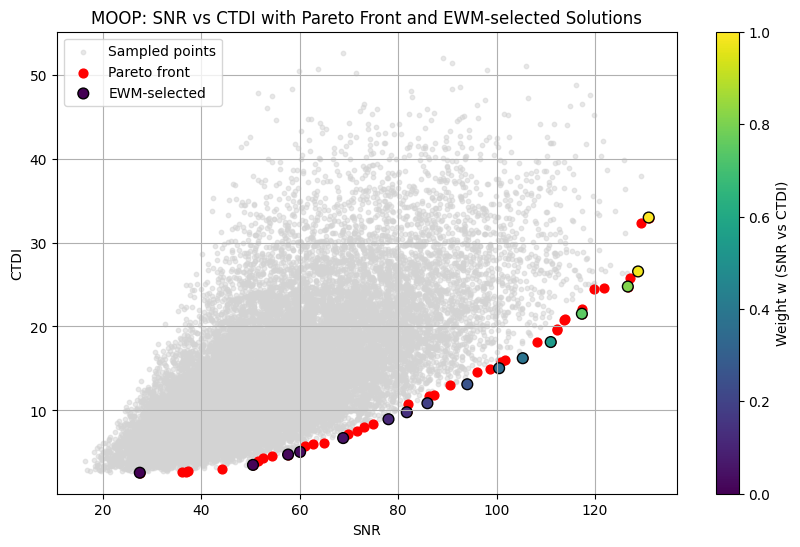

In [15]:
snr_vals = results["objectives"]["snr"]
ctdi_vals = results["objectives"]["ctdi"]

pareto_indices = results["pareto_indices"]

# Extract EWM-selected SNR and CTDI
ewm_snr = np.array([s['snr'] for s in selected_info])
ewm_ctdi = np.array([s['ctdi'] for s in selected_info])
ewm_weights = np.array([s['weight'] for s in selected_info])

# --- Plot ---
plt.figure(figsize=(10, 6))

# All sampled points (light gray)
plt.scatter(snr_vals, ctdi_vals, s=10, color='lightgray', alpha=0.5, label='Sampled points')

# Pareto front points (red)
plt.scatter(snr_vals[pareto_indices], ctdi_vals[pareto_indices], s=40, color='red', label='Pareto front')

# EWM-selected solutions (blue, colored by weight)
scatter = plt.scatter(ewm_snr, ewm_ctdi, s=60, c=ewm_weights, cmap='viridis', edgecolor='black', label='EWM-selected')

# Colorbar for weights
cbar = plt.colorbar(scatter)
cbar.set_label('Weight w (SNR vs CTDI)')

# Labels and title
plt.xlabel('SNR')
plt.ylabel('CTDI')
plt.title('MOOP: SNR vs CTDI with Pareto Front and EWM-selected Solutions')
plt.legend()
plt.grid(True)
plt.show()
